In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as geopd
from shapely.geometry import Point

import hdbscan
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

Создаем объект DataFrame из файла статистики абонента

In [2]:
ab_stat = pd.read_excel('ab_stat.xlsx', index_col=False)
ab_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22149 entries, 0 to 22148
Data columns (total 21 columns):
Unnamed: 0    22149 non-null int64
DATE          22149 non-null datetime64[ns]
DURATION      22149 non-null float64
TYPE          22149 non-null object
DIRECTION     22149 non-null object
MSISDN_A      22149 non-null int64
IMSI_A        22149 non-null int64
IMEI_A        21095 non-null float64
MSISDN_B      2670 non-null float64
LAC_A         22149 non-null int64
CELLID_A      22149 non-null int64
AZIMUTH_A     22149 non-null int64
ADDRESS_A     22073 non-null object
ROAMING       22149 non-null object
LAC           22149 non-null int64
CELL          22149 non-null int64
ADDRESS       22149 non-null object
LON           22149 non-null float64
LAT           22149 non-null float64
AZIMUTH       21862 non-null float64
LOCATION      20644 non-null object
dtypes: datetime64[ns](1), float64(6), int64(8), object(6)
memory usage: 3.5+ MB


In [37]:
lat_long = ab_stat[['DATE', 'LAT', 'LON', 'AZIMUTH', 'LOCATION', 'LAC', 'CELL']]
lat_long['LAC_CELL'] = lat_long.apply(lambda x: str(x.LAC) + '_' + str(x.CELL), axis=1)
lat_long = lat_long.drop(['LAC', 'CELL'], axis=1)
lat_long.head()

/Users/kosmosivanov/.conda/envs/TerVer/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DATE,LAT,LON,AZIMUTH,LOCATION,LAC_CELL
0,2018-05-03 12:46:52,56.28441,38.396787,200.0,outdoor,9021_63793
1,2018-05-03 13:46:52,56.28441,38.396787,200.0,outdoor,9021_63793
2,2018-05-03 14:46:52,56.28441,38.396787,200.0,outdoor,9021_63793
3,2018-05-09 11:04:52,56.28441,38.396787,200.0,outdoor,9021_63793
4,2018-05-09 19:04:52,56.28441,38.396787,200.0,outdoor,9021_63793


In [38]:
lat_long_index = lat_long[['DATE', 'LAC_CELL']]


In [39]:
lat_long_index.index = lat_long.DATE
lat_long_index = lat_long_index['LAC_CELL']
lat_long_index.head()

DATE
2018-05-03 12:46:52    9021_63793
2018-05-03 13:46:52    9021_63793
2018-05-03 14:46:52    9021_63793
2018-05-09 11:04:52    9021_63793
2018-05-09 19:04:52    9021_63793
Name: LAC_CELL, dtype: object

In [40]:
lat_long_index = lat_long_index[lat_long_index.map(lat_long_index.value_counts()) > 1]
lat_long_index.shape[0]

21925

In [41]:
r = lat_long_index.resample('H')
lat_long_index_1h = r.apply(lambda x: x.value_counts().index[0] if len(x.value_counts()) else None)
lat_long_index_1h.shape[0]

13818

In [4]:
lat_long_uniq = lat_long.drop_duplicates()
geodf = geopd.GeoDataFrame(lat_long_uniq, geometry=geopd.points_from_xy(lat_long_uniq.LAT, lat_long_uniq.LON))
geodf.head()

,LAT,LON,AZIMUTH,LOCATION,LAC,CELL,geometry
0,56.284410,38.396787,200.0,outdoor,9021,63793,POINT (56.28441 38.39679)
111,56.288675,38.210756,60.0,outdoor,5036,197534212,POINT (56.28867 38.21076)
115,55.715389,37.665209,310.0,outdoor,9767,197921795,POINT (55.71539 37.66521)
289,55.746933,37.707497,0.0,indoor,7740,39600,POINT (55.74693 37.70750)
297,55.748059,37.706855,0.0,indoor,9711,129006849,POINT (55.74806 37.70685)


In [5]:
def my_translate(g):
    if g.LOCATION == 'outdoor':
        gr_meter = 111120 # метров в 1 градусе широты
        dist = 300 # сдвиг в метрах
        dist_gr_lat = dist / gr_meter # сдвиг по широте в градусах
        dist_gr_lon = dist_gr_lat * np.cos(g.geometry.x) # сдвиг по долготе в градусах
        
        g.geometry = Point(g.geometry.x + np.cos(np.deg2rad(g.AZIMUTH)) * dist_gr_lat,
                  g.geometry.y + np.sin(np.deg2rad(g.AZIMUTH)) * dist_gr_lon)
    return g

 
geodf_300 = geodf.apply(my_translate, axis=1)

geodf_300.LAT = geodf_300.geometry.x
geodf_300.LON = geodf_300.geometry.y

geodf_300.head()

,LAT,LON,AZIMUTH,LOCATION,LAC,CELL,geometry
0,56.281873,38.395896,200.0,outdoor,9021,63793,POINT (56.28187 38.39590)
111,56.290025,38.213016,60.0,outdoor,5036,197534212,POINT (56.29002 38.21302)
115,55.717124,37.663818,310.0,outdoor,9767,197921795,POINT (55.71712 37.66382)
289,55.746933,37.707497,0.0,indoor,7740,39600,POINT (55.74693 37.70750)
297,55.748059,37.706855,0.0,indoor,9711,129006849,POINT (55.74806 37.70685)


In [6]:
plot_kwds = {'alpha' : 0.5, 's' : 30, 'linewidths':0, }

In [7]:
rad_uniq = np.deg2rad(geodf_300[['LAT', 'LON']])
rad_uniq.head()

,LAT,LON
0,0.982304,0.670135
111,0.982446,0.666943
115,0.972447,0.657358
289,0.972968,0.658120
297,0.972987,0.658109


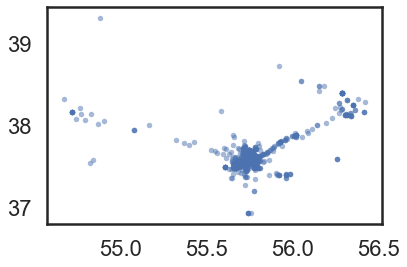

In [8]:
plt.scatter(lat_long_uniq.LAT, lat_long_uniq.LON, color='b', **plot_kwds)

In [9]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, metric='haversine')
clusterer.fit(rad_uniq)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='haversine', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [10]:
clusterer.labels_, clusterer.probabilities_

(array([ 3,  7, 46, 25, 26, 26, 26, 25, 26, 26, 25,  0, 50, 59, 72, 72, 64,
        51, 52, 62, 32, 32, 50, 47, 47, 50, 50, 61, 59, -1, -1,  3, -1,  2,
         2,  2, 71, 51, -1, -1, 48, -1, -1, -1, 13, 13, 13, 13, 13, 13, 13,
        -1, 42, 39, 39, -1, -1, 41, 41, 45, 45, 41, 31, 59, 69, 67, 59, 69,
        69, -1, 56, 30, -1, -1, 11, 11, 11, -1, 50, 51, 56, -1, 28, 28, 28,
        32, 32, -1, -1, -1, 43, 45, 72, 75, 26, 25, 25, -1, 48, 54, -1, 52,
        52, 51, -1, 38,  0,  0,  0,  0, -1, 43, 42, -1, 47, 47, -1, -1, 39,
        52, -1, 45, -1, 64, 73, 73, 69, 67, 42, 27, 27, 27, 27, 27, 27, 27,
        27, 43, 72, 54, -1, 45, 44, 44, 64, 72, 64, 18, 18, 67, 67, 67, 69,
        73, -1, 39, 42, 24, 12,  2,  3, 72, -1, 43, 44, 44, 44, 49, 57, 67,
        46, 49, 39, 49, 25, 26, -1, 45, 43, 44, 44, 44, 41, 41, -1,  5,  5,
        49, -1, 44, 37, 57, 46, 46, 64, 56, 45, 69, -1, -1, 49, 41, 69, -1,
        -1, -1, -1, 34, 34, 58, -1, 59, 32, -1, -1, 43, 24, 69, 56, 75, 76,
        46, 

In [11]:
len(set(clusterer.labels_))

78

In [12]:
geodf_300['cluster'] = clusterer.labels_
geodf_300['probabilities'] = clusterer.probabilities_
geodf_300.head()

,LAT,LON,AZIMUTH,LOCATION,LAC,CELL,geometry,cluster,probabilities
0,56.281873,38.395896,200.0,outdoor,9021,63793,POINT (56.28187 38.39590),3,1.0
111,56.290025,38.213016,60.0,outdoor,5036,197534212,POINT (56.29002 38.21302),7,1.0
115,55.717124,37.663818,310.0,outdoor,9767,197921795,POINT (55.71712 37.66382),46,1.0
289,55.746933,37.707497,0.0,indoor,7740,39600,POINT (55.74693 37.70750),25,1.0
297,55.748059,37.706855,0.0,indoor,9711,129006849,POINT (55.74806 37.70685),26,1.0


In [13]:
mx = (20, 30)
geodf_300_plot = geodf_300.loc[(geodf_300.cluster > mx[0]) & (geodf_300.cluster < mx[1])]

In [14]:
palette = sns.color_palette()


cluster_colors = [sns.desaturate(palette[row['cluster']-mx[1]], row['probabilities'])
                  if row['cluster'] >= 0 else (0.5, 0.5, 0.5) for row in
                  geodf_300_plot[['cluster', 'probabilities']].to_dict('records')]


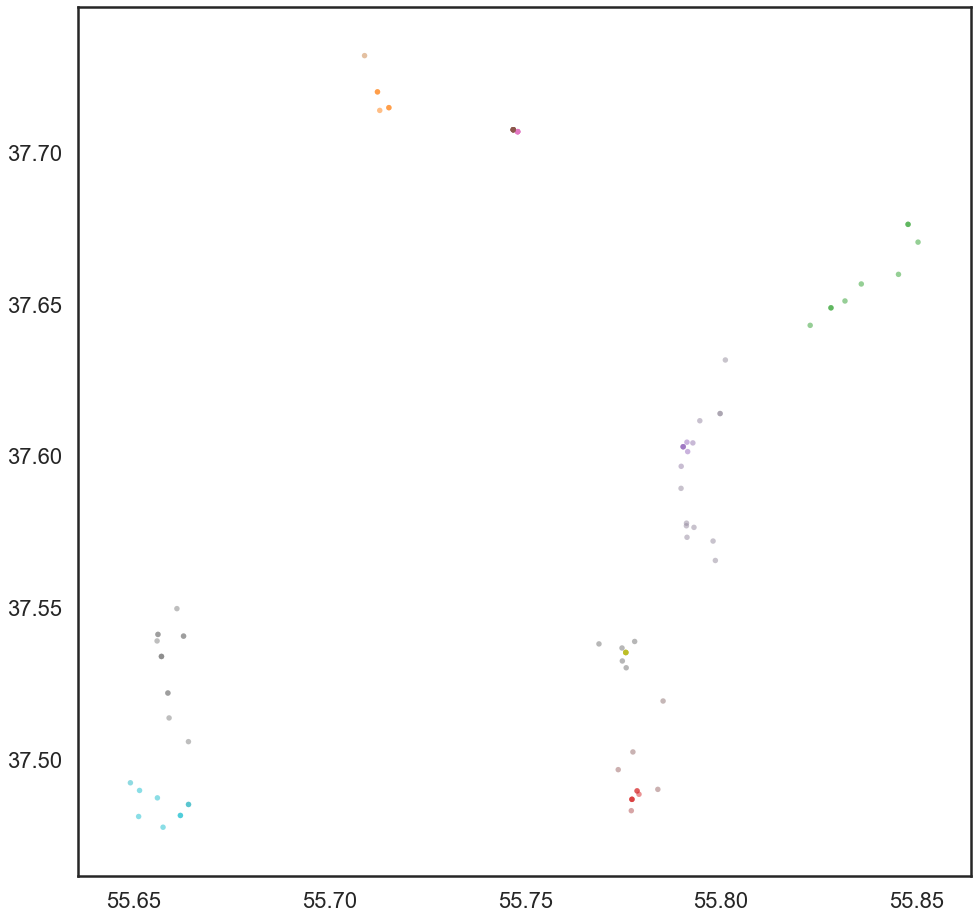

In [15]:
plt.figure(figsize=(16, 16))
plt.scatter(geodf_300_plot['LAT'], geodf_300_plot['LON'], c=cluster_colors, **plot_kwds)


In [18]:
lat_long_cluster = geodf.merge(geodf_300[['LAC', 'CELL', 'cluster']], left_on=['LAC', 'CELL'], right_on=['LAC', 'CELL'])

In [19]:
lat_long_cluster.drop_duplicates().groupby('cluster').count()

,LAT,LON,AZIMUTH,LOCATION,LAC,CELL,geometry
cluster,,,,,,,
-1,252,252,252,203,252,252,252
0,18,18,18,16,18,18,18
1,5,5,5,5,5,5,5
2,23,23,23,22,23,23,23
3,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...
72,12,12,12,8,12,12,12
73,7,7,7,5,7,7,7
74,7,7,7,3,7,7,7


In [ ]:

from ipyleaflet import Map, Marker, MarkerCluster

In [24]:

m = Map(center=(42.5, -41.6), zoom=2)
m.add_layer(MarkerCluster(
    markers=[Marker(location=geolocation.coords[0]) 
             for geolocation in lat_long_cluster.loc[lat_long_cluster.cluster == 2].geometry])
    )
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …